<a href="https://colab.research.google.com/github/jaredmccain-ux/pytorch-tutorial-learning-notes/blob/main/_downloads1/model-understanding/captumyt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://docs.pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Introduction](introyt1_tutorial.html) \|\|
[Tensors](tensors_deeper_tutorial.html) \|\|
[Autograd](autogradyt_tutorial.html) \|\| [Building
Models](modelsyt_tutorial.html) \|\| [TensorBoard
Support](tensorboardyt_tutorial.html) \|\| [Training
Models](trainingyt.html) \|\| **Model Understanding**

Model Understanding with Captum
===============================

Follow along with the video below or on
[youtube](https://www.youtube.com/watch?v=Am2EF9CLu-g). Download the
notebook and corresponding files
[here](https://pytorch-tutorial-assets.s3.amazonaws.com/youtube-series/video7.zip).



In [ ]:
# Run this cell to load the video
from IPython.display import display, HTML
html_code = """
<div style="margin-top:10px; margin-bottom:10px;">
  <iframe width="560" height="315" src="https://www.youtube.com/embed/Am2EF9CLu-g" frameborder="0" allow="accelerometer; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div>
"""
display(HTML(html_code))



[Captum](https://captum.ai/) ("comprehension" in Latin) is an open
source, extensible library for model interpretability built on PyTorch.

With the increase in model complexity and the resulting lack of
transparency, model interpretability methods have become increasingly
important. Model understanding is both an active area of research as
well as an area of focus for practical applications across industries
using machine learning. Captum provides state-of-the-art algorithms,
including Integrated Gradients, to provide researchers and developers
with an easy way to understand which features are contributing to a
model's output.

Full documentation, an API reference, and a suite of tutorials on
specific topics are available at the [captum.ai](https://captum.ai/)
website.

Introduction
------------

Captum's approach to model interpretability is in terms of
*attributions.* There are three kinds of attributions available in
Captum:

-   **Feature Attribution** seeks to explain a particular output in
    terms of features of the input that generated it. Explaining whether
    a movie review was positive or negative in terms of certain words in
    the review is an example of feature attribution.
-   **Layer Attribution** examines the activity of a model's hidden
    layer subsequent to a particular input. Examining the
    spatially-mapped output of a convolutional layer in response to an
    input image in an example of layer attribution.
-   **Neuron Attribution** is analagous to layer attribution, but
    focuses on the activity of a single neuron.

In this interactive notebook, we'll look at Feature Attribution and
Layer Attribution.

Each of the three attribution types has multiple **attribution
algorithms** associated with it. Many attribution algorithms fall into
two broad categories:

-   **Gradient-based algorithms** calculate the backward gradients of a
    model output, layer output, or neuron activation with respect to the
    input. **Integrated Gradients** (for features), **Layer Gradient \*
    Activation**, and **Neuron Conductance** are all gradient-based
    algorithms.
-   **Perturbation-based algorithms** examine the changes in the output
    of a model, layer, or neuron in response to changes in the input.
    The input perturbations may be directed or random. **Occlusion,**
    **Feature Ablation,** and **Feature Permutation** are all
    perturbation-based algorithms.

We'll be examining algorithms of both types below.

Especially where large models are involved, it can be valuable to
visualize attribution data in ways that relate it easily to the input
features being examined. While it is certainly possible to create your
own visualizations with Matplotlib, Plotly, or similar tools, Captum
offers enhanced tools specific to its attributions:

-   The `captum.attr.visualization` module (imported below as `viz`)
    provides helpful functions for visualizing attributions related to
    images.
-   **Captum Insights** is an easy-to-use API on top of Captum that
    provides a visualization widget with ready-made visualizations for
    image, text, and arbitrary model types.

Both of these visualization toolsets will be demonstrated in this
notebook. The first few examples will focus on computer vision use
cases, but the Captum Insights section at the end will demonstrate
visualization of attributions in a multi-model, visual
question-and-answer model.

Installation
------------

Before you get started, you need to have a Python environment with:

-   Python version 3.6 or higher
-   For the Captum Insights example, Flask 1.1 or higher and
    Flask-Compress (the latest version is recommended)
-   PyTorch version 1.2 or higher (the latest version is recommended)
-   TorchVision version 0.6 or higher (the latest version is
    recommended)
-   Captum (the latest version is recommended)
-   Matplotlib version 3.3.4, since Captum currently uses a Matplotlib
    function whose arguments have been renamed in later versions

To install Captum in an Anaconda or pip virtual environment, use the
appropriate command for your environment below:

With `conda`:

``` {.sh}
conda install pytorch torchvision captum flask-compress matplotlib=3.3.4 -c pytorch
```

With `pip`:

``` {.sh}
pip install torch torchvision captum matplotlib==3.3.4 Flask-Compress
```

Restart this notebook in the environment you set up, and you're ready to
go!

A First Example
---------------

To start, let's take a simple, visual example. We'll start with a ResNet
model pretrained on the ImageNet dataset. We'll get a test input, and
use different **Feature Attribution** algorithms to examine how the
input images affect the output, and see a helpful visualization of this
input attribution map for some test images.

First, some imports:


In [1]:
# Try installing without the explicit matplotlib version constraint.
# This might install a newer matplotlib, which could affect captum's visualization functions as noted in the tutorial.
!pip install torch torchvision captum Flask-Compress

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

Now we'll use the TorchVision model library to download a pretrained
ResNet. Since we're not training, we'll place it in evaluation mode for
now.


In [3]:
model = models.resnet18(weights='IMAGENET1K_V1')
model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 107MB/s]


The place where you got this interactive notebook should also have an
`img` folder with a file `cat.jpg` in it.


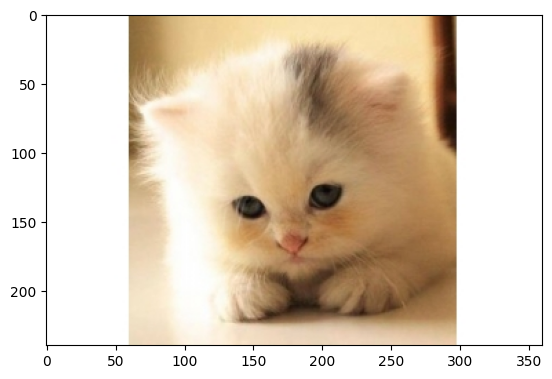

In [4]:
test_img = Image.open('img/cat.jpg')
test_img_data = np.asarray(test_img)
plt.imshow(test_img_data)
plt.show()

Our ResNet model was trained on the ImageNet dataset, and expects images
to be of a certain size, with the channel data normalized to a specific
range of values. We'll also pull in the list of human-readable labels
for the categories our model recognizes - that should be in the `img`
folder as well.


In [5]:
import requests
import os

# URL for a comprehensive imagenet_class_index.json
# Updated URL after previous 404 error
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
labels_path = 'img/imagenet_class_index.json'

# Ensure the 'img' directory exists
os.makedirs(os.path.dirname(labels_path), exist_ok=True)

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for HTTP errors
    with open(labels_path, 'w') as f:
        f.write(response.text)
    print(f"Successfully downloaded and saved '{labels_path}'.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
    print("Please ensure you have an active internet connection or try a different source for imagenet_class_index.json.")


Successfully downloaded and saved 'img/imagenet_class_index.json'.


In [6]:
# model expects 224x224 3-color image
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(test_img)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

labels_path = 'img/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

Now, we can ask the question: What does our model think this image
represents?


In [7]:
output = model(input_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Persian_cat ( 0.8415716886520386 )


这段代码是深度学习（特别是使用 PyTorch 框架）中非常经典的一段**图像分类推理（Inference）代码**。它的主要功能是将模型输出的原始分数转化为概率，提取出概率最高的一项，并将其转化为人类可读的标签。

下面我为你逐一详细解释其中涉及的核心函数及其参数含义：

### 1. `F.softmax(output, dim=1)`

这个函数的作用是将模型输出的“原始分数”（通常称为 logits）映射为**概率分布**。经过计算后，输出张量中的每个值都会在 0 到 1 之间，并且所有项加起来等于 1。

* **`output` (输入张量)**: 上一步骤 `model(input_img)` 的输出结果，通常形状为 `(batch_size, num_classes)`。
* **`dim=1` (计算维度)**: 指定在哪个维度上进行 softmax 计算。对于图像分类，形状通常是 `[批次大小, 类别数量]`（例如 `[1, 1000]` 表示 1 张图片，1000 个分类）。`dim=0` 代表批次维度，`dim=1` 代表类别维度。我们希望针对**各个类别**的得分计算概率，因此设为 1。

---

### 2. `torch.topk(output, 1)`

这个函数用于获取张量中**前  个最大值**及其对应的**索引**。

* **`output` (输入张量)**: 经过 softmax 处理后的概率分布。
* **`1` (参数 )**: 表示我们要取前  个最大的数。在这里 ，也就是寻找概率最高的那**1**个类别（Top-1 预测）。
* **返回值**: 这个函数返回一个元组，包含两个张量：
* `prediction_score`: 最大的概率值（例如 0.98）。
* `pred_label_idx`: 最大概率值对应的索引（例如 256，代表第 256 号类别）。



---

### 3. `squeeze_()` 与 `squeeze()`

这两个函数的作用是**降维**，具体来说是移除张量形状中所有大小为 1 的维度。
例如，如果 `pred_label_idx` 的形状是 `(1, 1)`（1个图片，1个最高概率索引），使用 squeeze 后形状会变成 0维的标量或 `(1,)`。

* **`squeeze_()` (带下划线)**: 表示**原地操作 (In-place operation)**。它会直接修改 `pred_label_idx` 本身，不占用额外的内存。
* **`squeeze()` (不带下划线)**: 在打印语句 `prediction_score.squeeze()` 中使用，它不会改变 `prediction_score` 本身，而是返回一个新的降维后的张量供后续调用。

---

### 4. `item()`

这是一个非常常用且关键的方法。它的作用是从一个**只包含单个元素的张量**中，提取出标准的 Python 数值（如普通的 float 或 int）。

* **用法原因**: `pred_label_idx` 即使经过降维，它仍然是一个 PyTorch 的 Tensor 对象（可能还存在于 GPU 上）。你无法直接用 Tensor 对象去当作字典 `idx_to_labels` 的键值。
* **具体表现**: `pred_label_idx.item()` 将 Tensor `[256]` 转换成了 Python 的整数 `256`。随后使用 `str()` 将其转为字符串，以便在标签字典中查找对应的类别名称。同样地，在 print 语句中，`prediction_score.squeeze().item()` 将概率 Tensor 提取成了普通的 Python 浮点数，方便打印。

---


We've confirmed that ResNet thinks our image of a cat is, in fact, a
cat. But *why* does the model think this is an image of a cat?

For the answer to that, we turn to Captum.


Feature Attribution with Integrated Gradients
=============================================

**Feature attribution** attributes a particular output to features of
the input. It uses a specific input - here, our test image - to generate
a map of the relative importance of each input feature to a particular
output feature.

[Integrated Gradients](https://captum.ai/api/integrated_gradients.html)
is one of the feature attribution algorithms available in Captum.
Integrated Gradients assigns an importance score to each input feature
by approximating the integral of the gradients of the model's output
with respect to the inputs.

In our case, we're going to be taking a specific element of the output
vector - that is, the one indicating the model's confidence in its
chosen category - and use Integrated Gradients to understand what parts
of the input image contributed to this output.

Once we have the importance map from Integrated Gradients, we'll use the
visualization tools in Captum to give a helpful representation of the
importance map. Captum's `visualize_image_attr()` function provides a
variety of options for customizing display of your attribution data.
Here, we pass in a custom Matplotlib color map.

Running the cell with the `integrated_gradients.attribute()` call will
usually take a minute or two.


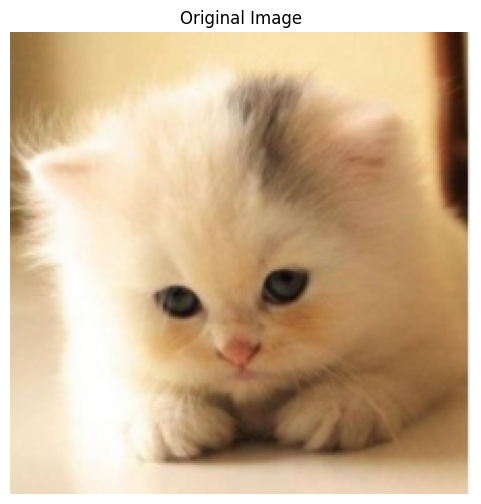

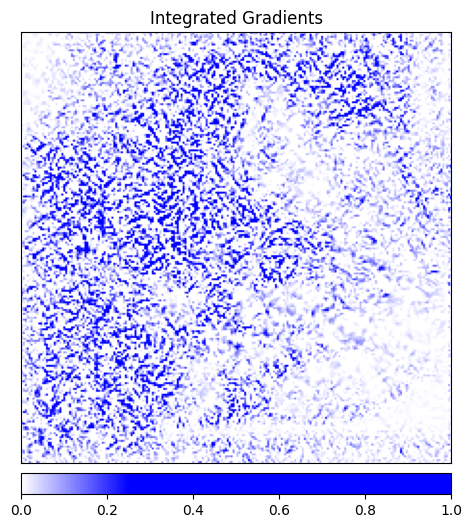

In [8]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to
attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison using matplotlib directly
original_image_np = np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0))
plt.figure(figsize=(6,6))
plt.imshow(original_image_np)
plt.title("Original Image")
plt.axis('off')
plt.show()

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             original_image_np,
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

In the image above, you should see that Integrated Gradients gives us
the strongest signal around the cat's location in the image.


这段代码进入了深度学习中非常硬核的领域：**模型可解释性（Model Interpretability）**。它使用的是著名的 **积分梯度（Integrated Gradients, IG）** 算法，目的是告诉我们：**“模型之所以预测这张图是‘狗’，是因为图片中哪些像素点起到了关键作用？”**

这里主要使用了 `Captum` 库（PyTorch 官方的可解释性工具库）和 `Matplotlib`。下面是详细拆解：

---

### 1. `IntegratedGradients(model)`

* **作用**：初始化积分梯度算法实例。它会分析模型，准备计算输入特征对输出结果的贡献度（Attribution）。
* **参数**：传入训练好的 `model`。

### 2. `integrated_gradients.attribute(...)`

这是最核心的计算步骤，计算每个像素的重要性。

* **`input_img`**: 待分析的输入图片张量。
* **`target=pred_label_idx`**: 告诉算法我们要分析**哪一个类别**的贡献。比如模型预测了 1000 个类，我们只关心模型预测为“第 256 号类”的原因。
* **`n_steps=200`**: 积分梯度的近似步数。IG 算法通过在“黑图”和“原图”之间插值来计算梯度。步数越多，计算越准，但耗时越长。200 是一个兼顾精度和速度的常用值。
* **返回值 `attributions_ig**`: 得到一个和原图形状一样的张量，里面的数值代表该像素对结果的**贡献权重**。

---

### 3. 图片预处理与 Matplotlib 展示

在绘图前，代码做了频繁的格式转换：

* **`.cpu().detach().numpy()`**: 将 GPU 上的张量转回 CPU，脱离计算图，并转为 Numpy 数组（绘图库只认 Numpy）。
* **`np.transpose(..., (1, 2, 0))`**: **非常关键！** PyTorch 的图片格式是 `[通道, 高, 宽]`，而绘图库（Matplotlib）要求是 `[高, 宽, 通道]`。这个函数把维度顺序给换过来。
* **`plt.imshow()` / `plt.axis('off')**`: 绘制原始图片并隐藏坐标轴。

---

### 4. `LinearSegmentedColormap` (自定义色板)

* **作用**：定义一种颜色映射规则。
* **含义**：这里定义了一个从**白色**（权重为 0）到**蓝色**（权重高）的渐变色。
* **效果**：在最后的热力图中，对预测贡献越大的像素，颜色会越蓝。

---

### 5. `viz.visualize_image_attr(...)`

这是 `Captum` 自带的专门可视化函数，把复杂的权重张量变成人类能看懂的图。

* **第一个参数**: `attributions_ig` 的 Numpy 形式（即计算出的像素贡献度）。
* **第二个参数**: `original_image_np`（原始图片），作为背景对比。
* **`method='heat_map'`**: 指定显示方式为**热力图**。
* **`cmap=default_cmap`**: 使用刚才定义的“白-蓝”色板。
* **`show_colorbar=True`**: 显示右侧的颜色刻度条，代表权重大小。
* **`sign='positive'`**: 只显示**正向贡献**（即哪些像素让模型“觉得它是这个类”）。如果是 `all`，则会同时显示正向和负向（哪些像素让模型觉得“它不是这个类”）的贡献。

---

### 总结

这段代码的终极目标是生成一张**“证据图”**：

1. 它先通过 IG 算法算出一堆权重数据。
2. 然后把这些数据像一张蓝色的薄膜一样盖在原图上。
3. **蓝色越深的地方，就是模型在做决定时盯着看的地方。**

Feature Attribution with Occlusion
==================================

Gradient-based attribution methods help to understand the model in terms
of directly computing out the output changes with respect to the input.
*Perturbation-based attribution* methods approach this more directly, by
introducing changes to the input to measure the effect on the output.
[Occlusion](https://captum.ai/api/occlusion.html) is one such method. It
involves replacing sections of the input image, and examining the effect
on the output signal.

Below, we set up Occlusion attribution. Similarly to configuring a
convolutional neural network, you can specify the size of the target
region, and a stride length to determine the spacing of individual
measurements. We'll visualize the output of our Occlusion attribution
with `visualize_image_attr_multiple()`, showing heat maps of both
positive and negative attribution by region, and by masking the original
image with the positive attribution regions. The masking gives a very
instructive view of what regions of our cat photo the model found to be
most "cat-like".


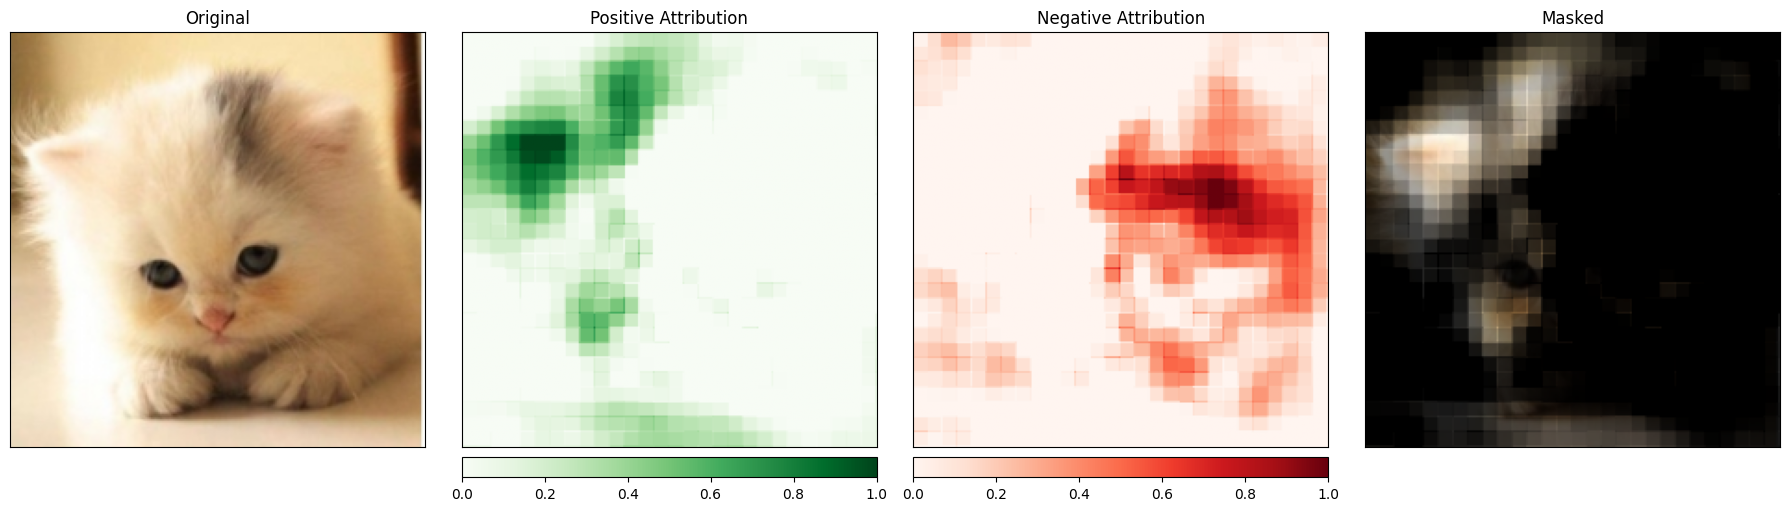

In [9]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

这段代码使用的是另一种模型可解释性方法：**遮挡分析（Occlusion Analysis）**。

如果说之前的“积分梯度”是基于数学导数来找重点，那么 **Occlusion** 的逻辑就非常“暴力直接”：**它拿一个色块在图片上到处挡。如果挡住某块区域后，模型预测概率大幅下降，说明这块区域非常重要。**

---

### 1. `Occlusion(model)`

* **作用**：初始化遮挡分析算法实例。
* **逻辑**：它会不断生成被遮挡的图片并喂给模型，观察输出的变化。

---

### 2. `occlusion.attribute(...)` 核心参数

这是该算法最关键的配置，决定了“色块”的大小和移动方式：

* **`input_img` & `target**`: 与之前一样，分别是输入图片和我们要分析的目标类别索引。
* **`sliding_window_shapes=(3, 15, 15)`**:
* 定义了“遮挡块”的大小。
* `(3, 15, 15)` 表示这是一个  像素的方块，`3` 代表 RGB 三个通道。
* **窗口越大**，分析越粗糙但速度快；**窗口越小**，分析越精细但计算量巨大。


* **`strides=(3, 8, 8)`**:
* 定义了“遮挡块”每次移动的步长（类似卷积）。
* 这里在长宽方向上各移动 8 个像素。因为步长（8）小于窗口大小（15），所以遮挡区域是有**重叠**的，这样得到的贡献图会更平滑。


* **`baselines=0`**:
* 定义“遮挡”后的填充颜色。`0` 通常代表黑色（也可以传均值）。即用黑色的方块去覆盖图片。



---

### 3. `viz.visualize_image_attr_multiple(...)`

这个函数与之前的不同点在于它能**一次性并排画出多张图**进行对比。

* **前两个参数**: 处理后的贡献度数据和原始图片数据（依然需要 `transpose` 换轴）。
* **`["original_image", "heat_map", "heat_map", "masked_image"]`**:
* 指定这一排要画 4 张图，类型分别是：原图、热力图、热力图、被遮盖的图像。


* **`["all", "positive", "negative", "positive"]`**:
* 这是对应上面 4 张图的**显示符号（Sign）**：
* `all`: 显示所有贡献。
* `positive`: 只显示**正向贡献**（哪些区域支持预测结果）。
* `negative`: 只显示**负向贡献**（哪些区域干扰了预测结果，让模型觉得“不是这个类”）。




* **`titles`**: 对应每张子图的标题。
* **`fig_size=(18, 6)`**: 设置整个大图的尺寸（宽 18，高 6）。

---

### 4. 这段代码在干什么？

运行后你会看到一横排四张图：

1. **Original**: 你的原始图片。
2. **Positive Attribution**: 哪些地方被挡住后模型最痛苦（也就是最重要的区域，通常是物体的核心特征）。
3. **Negative Attribution**: 哪些地方挡住后，模型反而更确信预测结果了（背景杂质）。
4. **Masked**: 将重要特征叠加在原图上的效果。

---

### 💡 小贴士：Occlusion vs Integrated Gradients

* **Integrated Gradients (IG)**: 像医生的 **X光**，通过数学计算精细地观察每一个像素。
* **Occlusion**: 像是在做 **“排除法”实验**，逻辑更符合直觉，但结果通常比 IG 看起来“块状感”更强。


Again, we see greater significance placed on the region of the image
that contains the cat.


Layer Attribution with Layer GradCAM
====================================

**Layer Attribution** allows you to attribute the activity of hidden
layers within your model to features of your input. Below, we'll use a
layer attribution algorithm to examine the activity of one of the
convolutional layers within our model.

GradCAM computes the gradients of the target output with respect to the
given layer, averages for each output channel (dimension 2 of output),
and multiplies the average gradient for each channel by the layer
activations. The results are summed over all channels. GradCAM is
designed for convnets; since the activity of convolutional layers often
maps spatially to the input, GradCAM attributions are often upsampled
and used to mask the input.

Layer attribution is set up similarly to input attribution, except that
in addition to the model, you must specify a hidden layer within the
model that you wish to examine. As above, when we call `attribute()`, we
specify the target class of interest.


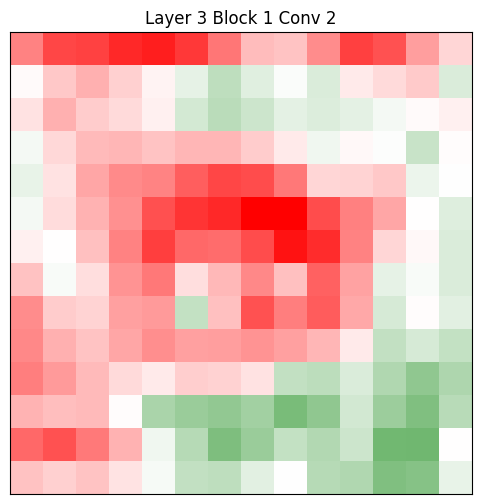

In [10]:
layer_gradcam = LayerGradCam(model, model.layer3[1].conv2)
attributions_lgc = layer_gradcam.attribute(input_img, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")

这段代码使用的是深度学习可视化中最著名的算法之一：**Grad-CAM (Gradient-weighted Class Activation Mapping)**。

如果说之前的 **Integrated Gradients** 是看“像素”，**Occlusion** 是看“区域”，那么 **Grad-CAM** 就是在看**“大脑的思维层”**。它通过分析神经网络**中间层**的特征图（Feature Maps）来确定模型在关注什么。

以下是详细拆解：

---

### 1. `LayerGradCam(model, model.layer3[1].conv2)`

这是初始化 Grad-CAM 解释器。

* **第一个参数 `model**`: 你的分类模型。
* **第二个参数 `model.layer3[1].conv2**`: **最关键的参数**。
* Grad-CAM 需要指定一个具体的**卷积层**来提取特征。
* 这里指向的是 ResNet 等模型中第 3 个 Block 组、第 2 个残差块里的第二个卷积层。
* **原理**：深层的卷积层通常包含高度抽象的语义信息（比如“耳朵的轮廓”、“眼睛”），在这里做可视化效果最直观。



---

### 2. `layer_gradcam.attribute(...)`

* **作用**：计算目标类别对指定卷积层特征图的贡献度。
* **`input_img`**: 你的输入图片。
* **`target=pred_label_idx`**: 告诉算法，我们要看模型判定为“某类别”时，该卷积层的哪些神经元最兴奋。

---

### 3. 可视化中的数据处理

这里的处理方式和你之前的代码略有不同，使用了 `permute`：

`attributions_lgc[0].cpu().permute(1, 2, 0).detach().numpy()`

* **`attributions_lgc[0]`**: 获取第一个样本的归因结果。
* **`.permute(1, 2, 0)`**:
* 这和 `np.transpose(..., (1, 2, 0))` 的作用**完全一样**，只是它是 PyTorch 张量自带的方法。
* 它将维度从 `(C, H, W)` 调整为 `(H, W, C)`，以符合绘图库的要求。


* **`.cpu().detach().numpy()`**: 依然是那套标准流程：从 GPU 挪到 CPU，断开计算图，转成 Numpy 数组。

---

### 4. `viz.visualize_image_attr(...)`

* **`sign="all"`**:
* 这意味着它会同时显示**正向（Positive）**和**负向（Negative）**的影响。
* 正向通常表示“支持模型预测为该类别的特征”，负向表示“反对此预测的特征”。


* **`title="Layer 3 Block 1 Conv 2"`**: 给画出来的图打个标签，提醒你这是在看哪一层。

---

### 💡 深度对比：为什么用 Grad-CAM？

| 方法 | 观察视角 | 优点 | 缺点 |
| --- | --- | --- | --- |
| **Integrated Gradients** | 像素级 | 极度精确，数学严谨 | 噪点多，有时看不出整体轮廓 |
| **Occlusion** | 区域级 | 直观，像是在做排除法 | 计算慢，方块感强，不够平滑 |
| **Grad-CAM** | **语义层** | **非常像人类的视觉重点**，背景干净 | 精度受限于卷积层的大小（通常比较模糊） |


We'll use the convenience method `interpolate()` in the
[LayerAttribution](https://captum.ai/api/base_classes.html?highlight=layerattribution#captum.attr.LayerAttribution)
base class to upsample this attribution data for comparison to the input
image.


torch.Size([1, 1, 14, 14])
torch.Size([1, 1, 224, 224])
torch.Size([1, 3, 224, 224])


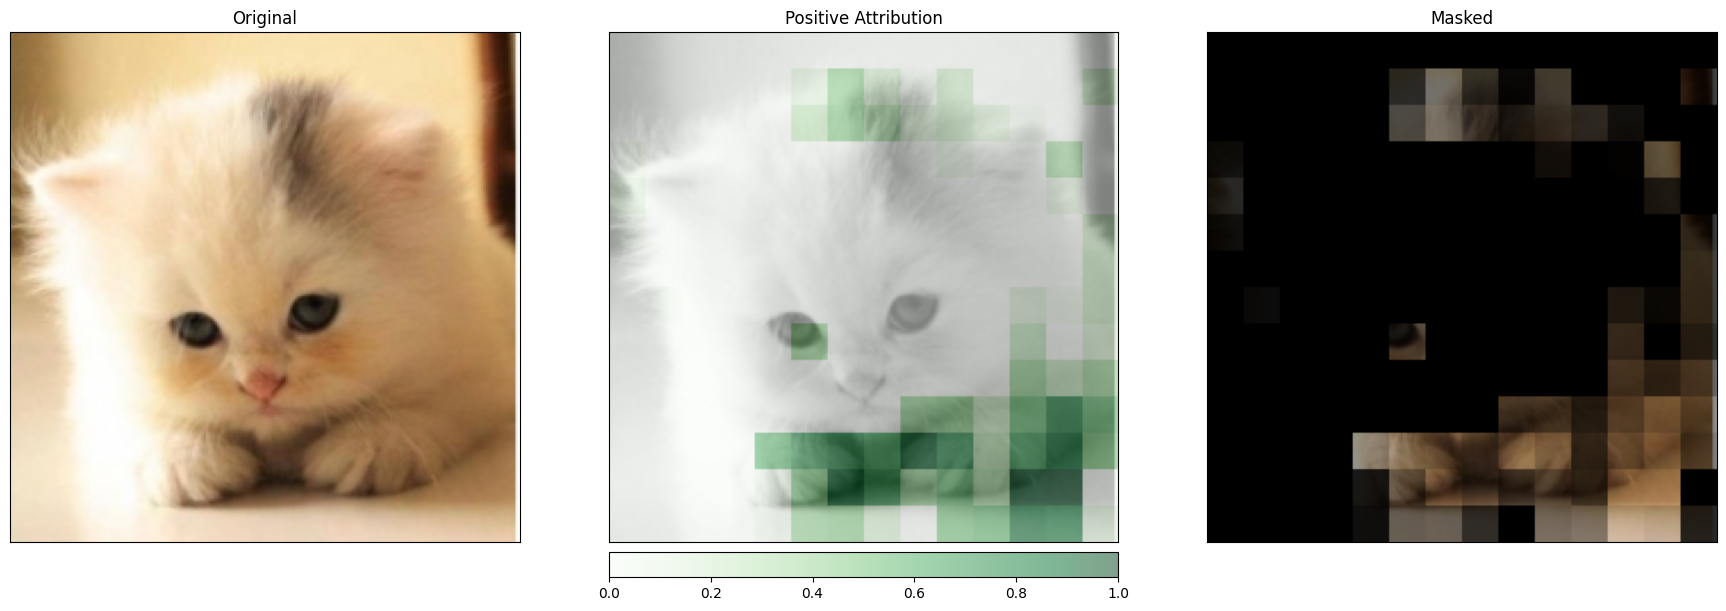

In [11]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, input_img.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(input_img.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      transformed_img.permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

Visualizations such as this can give you novel insights into how your
hidden layers respond to your input.


Visualization with Captum Insights
==================================

Captum Insights is an interpretability visualization widget built on top
of Captum to facilitate model understanding. Captum Insights works
across images, text, and other features to help users understand feature
attribution. It allows you to visualize attribution for multiple
input/output pairs, and provides visualization tools for image, text,
and arbitrary data.

In this section of the notebook, we'll visualize multiple image
classification inferences with Captum Insights.

First, let's gather some image and see what the model thinks of them.
For variety, we'll take our cat, a teapot, and a trilobite fossil:


In [12]:
imgs = ['img/cat.jpg', 'img/teapot.jpg', 'img/trilobite.jpg']

for img in imgs:
    img = Image.open(img)
    transformed_img = transform(img)
    input_img = transform_normalize(transformed_img)
    input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

    output = model(input_img)
    output = F.softmax(output, dim=1)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()
    predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
    print('Predicted:', predicted_label, '/', pred_label_idx.item(), ' (', prediction_score.squeeze().item(), ')')

Predicted: Persian_cat / 283  ( 0.8415716886520386 )
Predicted: teapot / 849  ( 0.8886135816574097 )
Predicted: trilobite / 69  ( 0.9292678833007812 )


...and it looks like our model is identifying them all correctly - but
of course, we want to dig deeper. For that we'll use the Captum Insights
widget, which we configure with an `AttributionVisualizer` object,
imported below. The `AttributionVisualizer` expects batches of data, so
we'll bring in Captum's `Batch` helper class. And we'll be looking at
images specifically, so well also import `ImageFeature`.

We configure the `AttributionVisualizer` with the following arguments:

-   An array of models to be examined (in our case, just the one)
-   A scoring function, which allows Captum Insights to pull out the
    top-k predictions from a model
-   An ordered, human-readable list of classes our model is trained on
-   A list of features to look for - in our case, an `ImageFeature`
-   A dataset, which is an iterable object returning batches of inputs
    and labels - just like you'd use for training


In [13]:
from captum.insights import AttributionVisualizer, Batch
from captum.insights.attr_vis.features import ImageFeature

# Baseline is all-zeros input - this may differ depending on your data
def baseline_func(input):
    return input * 0

# merging our image transforms from above
def full_img_transform(input):
    i = Image.open(input)
    i = transform(i)
    i = transform_normalize(i)
    i = i.unsqueeze(0)
    return i


input_imgs = torch.cat(list(map(lambda i: full_img_transform(i), imgs)), 0)

visualizer = AttributionVisualizer(
    models=[model],
    score_func=lambda o: torch.nn.functional.softmax(o, 1),
    classes=list(map(lambda k: idx_to_labels[k][1], idx_to_labels.keys())),
    features=[
        ImageFeature(
            "Photo",
            baseline_transforms=[baseline_func],
            input_transforms=[],
        )
    ],
    dataset=[Batch(input_imgs, labels=[282,849,69])]
)

Note that running the cell above didn't take much time at all, unlike
our attributions above. That's because Captum Insights lets you
configure different attribution algorithms in a visual widget, after
which it will compute and display the attributions. *That* process will
take a few minutes.

Running the cell below will render the Captum Insights widget. You can
then choose attributions methods and their arguments, filter model
responses based on predicted class or prediction correctness, see the
model's predictions with associated probabilities, and view heatmaps of
the attribution compared with the original image.


In [14]:
visualizer.render()

CaptumInsights(insights_config={'classes': ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhe…

Output()